# Monte Carlo Simulations of Call and Put payoffs
- Acts as benchmark
- GBM to simulate prices
- The datasets for MC are the base ones used for IPCA5 and IPCA20 Calls and Puts, simplified to contain only necessary information to run the simulations such as spot price, strike price, time to maturity, risk-free rate and implied volatility to reduce load

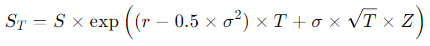

In [ ]:
import dask.dataframe as dd
import numpy as np
import pandas as pd
from tqdm import tqdm

## Test Set

In [ ]:
ddf = dd.read_csv('Dataset for MC Test.csv')

In [ ]:
# Parameters
num_simulations = 10000
dt = 1/252  # daily steps
mu = ddf['risk_free']  # drift
sigma = ddf['impl_volatility']

# Simulating asset paths
def monte_carlo_payoffs(row):
    S0 = row['spot_price']
    K = row['strike_price']
    T = row['time_to_maturity_OPT']
    r = row['risk_free']
    sigma = row['impl_volatility']
    
    # Random price paths
    np.random.seed(42)  # for reproducibility
    Z = np.random.standard_normal(num_simulations)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    # Calculating payoffs
    call_payoffs = np.maximum(ST - K, 0)
    put_payoffs = np.maximum(K - ST, 0)
    
    # Averaging payoffs as benchmark
    return pd.Series({
        'Monte_Carlo_Call': call_payoffs.mean(),
        'Monte_Carlo_Put': put_payoffs.mean()
    })

# Applying the simulation
def apply_monte_carlo(df):
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Simulating Monte Carlo Payoffs"):
        results.append(monte_carlo_payoffs(row))
    return pd.DataFrame(results)

monte_carlo_results = ddf.map_partitions(lambda df: apply_monte_carlo(df)).compute()

# Merge with testing set and saving
ddf = ddf.compute()
ddf = pd.concat([ddf, monte_carlo_results], axis=1)
ddf.to_csv('MC Test Results.csv', index=False)

## Covid Set

In [ ]:
ddf = dd.read_csv('Dataset for MC COVID.csv')

In [ ]:
# Parameters
num_simulations = 10000
dt = 1/252  # daily steps
mu = ddf['risk_free']  # drift
sigma = ddf['impl_volatility']

# Simulate asset paths
def monte_carlo_payoffs(row):
    S0 = row['spot_price']
    K = row['strike_price']
    T = row['time_to_maturity_OPT']
    r = row['risk_free']
    sigma = row['impl_volatility']
    
    # Generate random price paths
    np.random.seed(42)  # for reproducibility
    Z = np.random.standard_normal(num_simulations)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    # Calculate payoffs
    call_payoffs = np.maximum(ST - K, 0)
    put_payoffs = np.maximum(K - ST, 0)
    
    # Average payoffs as benchmark
    return pd.Series({
        'Monte_Carlo_Call': call_payoffs.mean(),
        'Monte_Carlo_Put': put_payoffs.mean()
    })

# Apply the simulation with tqdm progress bar
def apply_monte_carlo(df):
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Simulating Monte Carlo Payoffs"):
        results.append(monte_carlo_payoffs(row))
    return pd.DataFrame(results)

monte_carlo_results = ddf.map_partitions(lambda df: apply_monte_carlo(df)).compute()

# Merge with original dataframe
ddf = ddf.compute()
ddf = pd.concat([ddf, monte_carlo_results], axis=1)

# Save or proceed with your enhanced dataset
ddf.to_csv('MC COVID Results.csv', index=False)
